# **1. Visualize EF5 outputs for Ivory Coast Flash Flood Event**



In [63]:
## Install some necessary libraries
!pip install rasterio


In [64]:
#import
import xml.etree.ElementTree as ET
import numpy as np
from google.colab import files
import os
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import xml.etree.ElementTree as ET
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='rasterio')
import pandas as pd
import glob
from datetime import timedelta
import time
from matplotlib.dates import DateFormatter, AutoDateLocator
from matplotlib.ticker import MaxNLocator

Upload the files to google collab

In [134]:
uploaded = files.upload()

Saving maxq.20180618.183000.tif to maxq.20180618.183000.tif
Saving maxunitq.20180618.183000.tif to maxunitq.20180618.183000 (2).tif
Saving qpeaccum.20180618.183000.tif to qpeaccum.20180618.183000 (1).tif
Saving qpfaccum.20180618.183000.tif to qpfaccum.20180618.183000.tif


If you want to list the files use:

In [ ]:
os.listdir()


['.config',
 'qpeaccum.20180618.183000.tif',
 'maxunitq.20180618.183000.tif',
 'ts.1006007.crest.csv',
 'maxunitq.20180618.183000 (1).tif',
 '1006007_daily_Q.csv',
 'FLASHunitQColormap_Visual.qml',
 'sample_data']

For visualize the EF5 outputs in the desing colorscale we need to upload and use the color palette:

In [ ]:
uploaded_colorramp = files.upload()

Saving FLASHunitQColormap_Visual.qml to FLASHunitQColormap_Visual.qml


This section defines a function called *create_map_from_tif*. This function takes one argument:

**tif_file_path**: This represents the path to the GeoTIFF file that you want to visualize.
The purpose of the function is to open the GeoTIFF, read its data, and then create a visual representation of it as a map.

In [131]:
def parse_qml_colormap(qml_file_path):
    """
    Parses the .qml file to extract colormap information from the specific structure in QGIS QML files.

    Args:
        qml_file_path: The path to the .qml file.

    Returns:
        A list of color tuples (R, G, B).
    """
    try:
        tree = ET.parse(qml_file_path)
        root = tree.getroot()

        colors = []
        # Loop through each <item> inside <colorrampshader>
        for item in root.iter('item'):
            color = item.attrib.get('color')
            if color:
                # Convert the hex color (e.g., "#595a5a") to RGB format
                try:
                    # Remove the '#' and extract the R, G, B components
                    r = int(color[1:3], 16) / 255  # Normalize to [0, 1]
                    g = int(color[3:5], 16) / 255
                    b = int(color[5:7], 16) / 255
                    colors.append((r, g, b))
                except ValueError:
                    print(f"Skipping invalid color: {color}")

        if not colors:
            print("No valid colors found in QML file.")
        return colors

    except Exception as e:
        print(f"Error parsing QML file: {e}")
        return []

def create_map_from_tif(tif_file_path, qml_file_path, zoom):
    """
    Reads a GeoTIFF file and generates a map visualization using a custom colormap.

    Args:
        tif_file_path: The path to the GeoTIFF file.
        qml_file_path: The path to the QML colormap file.
    """
    try:
        # Parse the colormap from the QML file
        colormap = parse_qml_colormap(qml_file_path)

        # If no valid colors are found, raise an error
        if not colormap:
            raise ValueError("No valid colormap found in QML file.")

        # Create a custom colormap using matplotlib
        import matplotlib.colors as mcolors
        from matplotlib.colors import ListedColormap
        custom_cmap = ListedColormap(colormap)
        custom_cmap.set_extremes(over='white')
        levels_map = [0, 0.5, 0.75, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 6, 7, 8, 10, 13, 15]
        norm = mcolors.BoundaryNorm(boundaries=levels_map, ncolors=custom_cmap.N, extend='max')

        rasterio.env.GTIFF_SRS_SOURCE = 'EPSG'

        # Open the GeoTIFF file
        with rasterio.open(tif_file_path) as src:
            band1 = src.read(1)  # Read the first band

            # Replace -9999 with np.nan (for invalid or missing data)
            band1 = np.where(band1 == -9999, np.nan, band1)

            # Create latitude and longitude arrays using the extent and raster size
            extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]


            # Generate longitude and latitude arrays
            lon = np.linspace(extent[0], extent[1], band1.shape[1])  # Longitude from left to right
            lat = np.linspace(extent[3], extent[2], band1.shape[0])  # Latitude from top to bottom

            # Create a meshgrid from lat and lon to use in plotting
            lon_grid, lat_grid = np.meshgrid(lon, lat)

            if zoom:
              limits = [-5, -3, 4.75, 7]
            else:
              limits = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

            # The point's latitude and longitude
            point_lat = 5.321
            point_lon = -4.018

            # Display the image using contourf

            plt.figure(figsize=(13, 7))
            levels_unitq = [0, 0.5, 0.75, 1, 1.5, 2, 2.5, 3, 4, 5, 6, 7, 8, 10, 13, 15]

            # Create the colormap with contourf
            contours = plt.contourf(lon_grid, lat_grid, band1, levels=levels_unitq, extend = "max" ,cmap=custom_cmap, norm=norm)
            plt.scatter(x=point_lon, y=point_lat, c='b', marker ="*", s=20, label='FF event')

            # Set the extent of the plot
            plt.xlim(limits[0], limits[1])
            plt.ylim(limits[2], limits[3])

            plt.title(f"Map from {tif_file_path}")
            plt.xlabel("Longitude")
            plt.ylabel("Latitude")

            # Add colorbar for contour levels
            cbar = plt.colorbar(contours, extend='max')
            cbar.set_label(r"Max Unit Q ($\mathrm{m^3 s^{-1} km^{-2}}$)")
            cbar.set_ticks(levels_unitq)
            plt.legend()

            plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {tif_file_path}")
    except rasterio.errors.RasterioIOError:
        print(f"Error: Could not read the GeoTIFF file. Check the file format or path.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


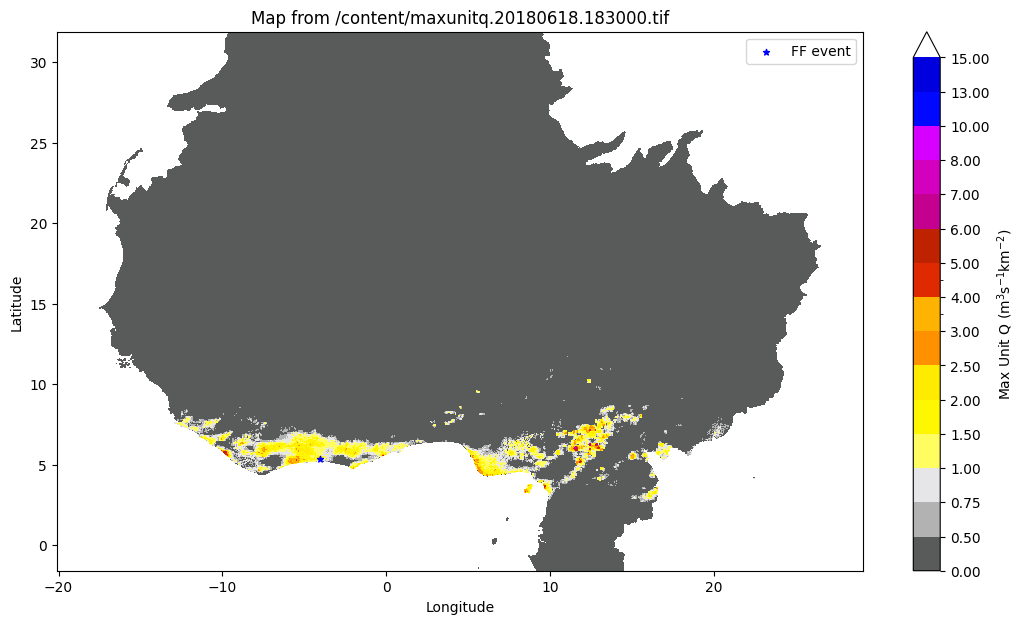

In [133]:
tif_file = '/content/maxunitq.20180618.183000.tif'
qml_file_path = '/content/FLASHunitQColormap_Visual.qml'
create_map_from_tif(tif_file, qml_file_path, zoom = False)


Now lets zoom in




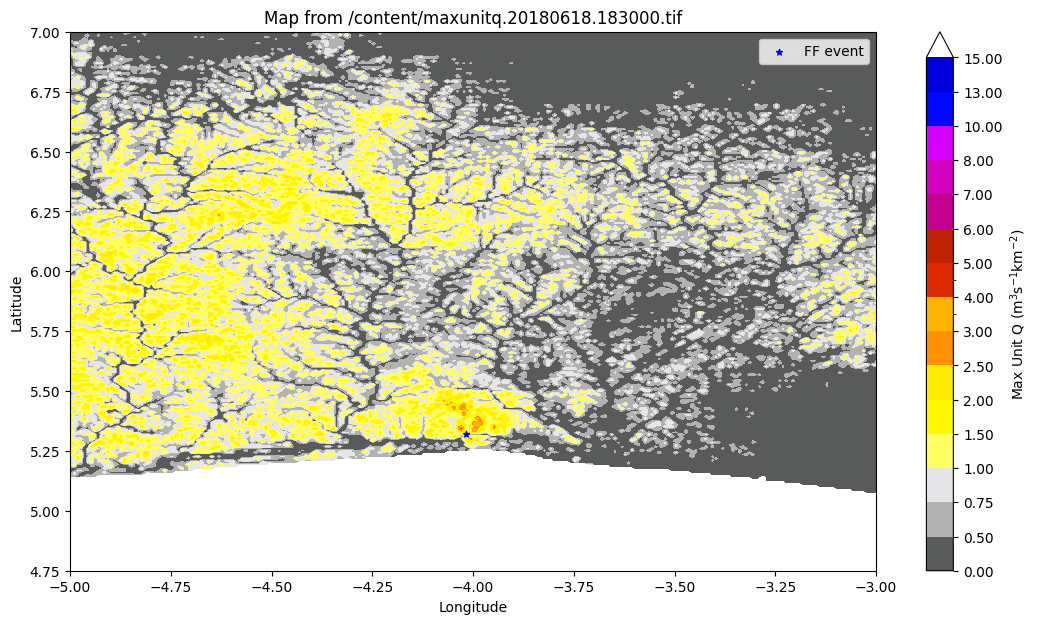

In [135]:
tif_file = '/content/maxunitq.20180618.183000.tif'
qml_file_path = '/content/FLASHunitQColormap_Visual.qml'
create_map_from_tif(tif_file, qml_file_path,zoom=True)

# Time series analysis for EF5 outputs at 90 meters resolution

Lets use a time series from the model and compare it with the avialable observacions. For this case, the model has been warmed up for a year.

In [ ]:
def calculate_error_metrics(df_simulado, df_observado):
    # Merged the two datasets so the dates coincide
    df_merged = pd.merge(df_simulado, df_observado, how='outer', left_index=True, right_index=True, suffixes=('_simulado', '_observado'))

    # Calcular the error metrics
    df_valid = df_merged.dropna(subset=['Discharge(m^3 s^-1)', 'discharge'])
    from sklearn.metrics import mean_squared_error
    rmse = mean_squared_error(df_valid['discharge'],df_valid['Discharge(m^3 s^-1)'],squared=False)
    bias = (df_valid['Discharge(m^3 s^-1)'] - df_valid['discharge']).mean()
    nse = 1 - ((df_valid['Discharge(m^3 s^-1)'] - df_valid['discharge']) ** 2).sum() / ((df_valid['discharge'] - df_valid['discharge'].mean()) ** 2).sum()

    return rmse, bias, nse

In [164]:
def plotting(Q_daily_df, Q_obs, nse, bias, rmse):

    fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(30,10))
    ax1 = plt.subplot(1,1,1)
    ax1.scatter(Q_obs.index, Q_obs['discharge'], color = 'black', label='Observed')
    ax1.plot(Q_daily_df.index, Q_daily_df['Discharge(m^3 s^-1)'], color='blue', label='Simulated', linewidth=2)
    ax1.set_xlabel('Date', fontsize=20)
    ax1.set_ylabel('Discharge (m^3/s)',fontsize=20, color='blue')
    ax1.tick_params(axis='y', labelcolor='blue',labelsize=16)
    ax1.set_xlim(Q_daily_df.index.values[0], Q_daily_df.index.values[-1])
    ax1.xaxis.set_major_locator(AutoDateLocator(minticks=10, maxticks=20))
    ax1.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
    ax1.tick_params(axis='x',labelsize=16,rotation=30)
    ax1.grid(True, which='major', linestyle='--', linewidth=0.5)
    ax1.set_ylim(0,Q_daily_df['Discharge(m^3 s^-1)'].max()+200)

    # Create a secondary y-axis
    ax2 = ax1.twinx()
    #ax2.plot(Q_daily_df.index,Q_daily_df['Precip (mm d^-1)'],color='rebeccapurple',linewidth=2, alpha = 0.9)
    ax2.bar(Q_daily_df.index,Q_daily_df['Precip (mm d^-1)'],color='rebeccapurple',alpha=1,width=0.8,align='center')
    ax2.set_ylim(0,Q_daily_df['Precip (mm d^-1)'].max()+200)
    ax2.invert_yaxis()
    ax2.set_ylabel('Precip (mm d^-1)', color='rebeccapurple',fontsize=20)  # we already handled the x-label with ax1
    ax2.tick_params(axis='y', labelcolor='rebeccapurple',labelsize=16)
    ax2.yaxis.set_major_locator(MaxNLocator(nbins=10))

    # Agrega texto con métricas
    ax = plt.gca()
    plt.text(0.02, 0.95, f'RMSE: {rmse:.2f}\nBias: {bias:.2f}\nNSE: {nse:.2f}', transform=ax.transAxes, fontsize=16,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    ax1.legend(fontsize=16)
    plt.title('GAUGE= name')

    plt.show()
    #plt.savefig(path_data+"plots/"+file[len(prefix)+3:-10]+'.png',bbox_inches='tight')

In [ ]:
timeseries = files.upload()

Saving ts.1006007.crest.csv to ts.1006007.crest.csv
Saving 1006007_daily_Q.csv to 1006007_daily_Q.csv


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


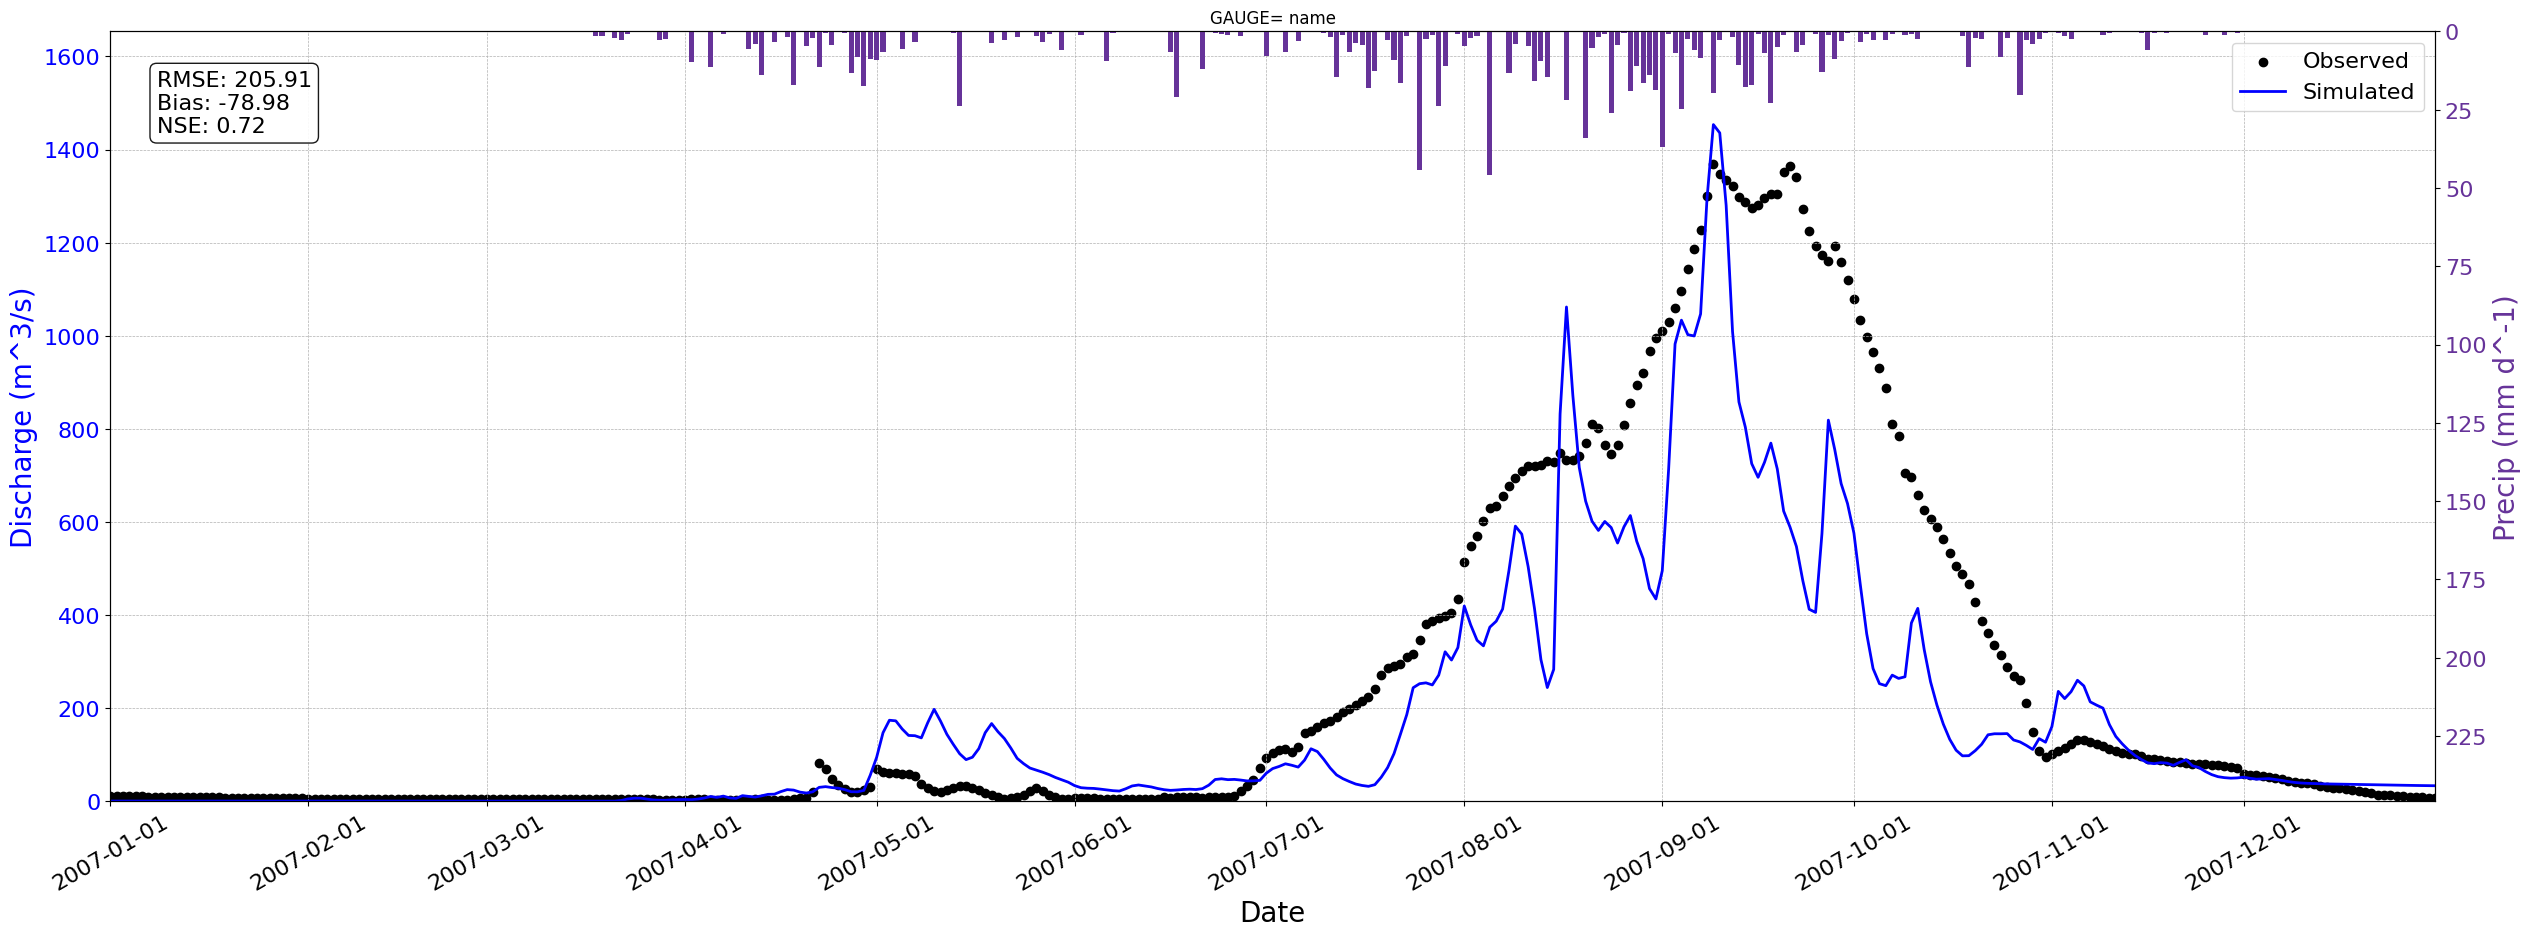

In [165]:
ef5_file = pd.read_csv('ts.1006007.crest.csv', sep =',')
ef5_file['Time'] =  pd.to_datetime(ef5_file['Time'])
ef5_file = ef5_file.set_index('Time')

file_obs = pd.read_csv('1006007_daily_Q.csv', sep =',')
file_obs['date'] =  pd.to_datetime(file_obs['date'])
file_obs = file_obs.set_index('date')

Q_observed_filtered = file_obs[(file_obs.index.year >= 2007) & (file_obs.index.year < 2008)]

initial_data = Q_observed_filtered.index[0]
final_data = Q_observed_filtered.index[-1]

Q_modeled_filtered = ef5_file.loc[(ef5_file.index >= initial_data) & (ef5_file.index <= final_data)]

#Calculate 3 different error metrics
rmse, bias, nse = calculate_error_metrics(Q_modeled_filtered['Discharge(m^3 s^-1)'], Q_observed_filtered['discharge'])
plotting(Q_modeled_filtered, Q_observed_filtered, nse, bias, rmse)